In [1]:
import os
import cv2
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras import backend as K
import tensorflow as tf


color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

Using TensorFlow backend.


In [0]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
#tf.set_random_seed(seed)

# Make the augmentation sequence deterministic
aug.seed(seed)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# As usual, define some paths first to make life simpler
training_data = Path('./drive/My Drive/monkey spicies/training_data') 
validation_data = Path('./drive/My Drive/monkey spicies/validation') 
labels_path = Path('./drive/My Drive/monkey spicies/monkey_labels.txt')

In [10]:
labels_info = []

# Read the file
lines = labels_path.read_text().strip().splitlines()[1:]
for line in lines:
    line = line.split(',')
    line = [x.strip(' \n\t\r') for x in line]
    line[3], line[4] = int(line[3]), int(line[4])
    line = tuple(line)
    labels_info.append(line)
    
# Convert the data into a pandas dataframe
labels_info = pd.DataFrame(labels_info, columns=['Label', 'Latin Name', 'Common Name', 
                                                 'Train Images', 'Validation Images'], index=None)
# Sneak peek 
labels_info.head(10)

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [20]:
# Create a dictionary to map the labels to integers
labels_dict= {'n0':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'n5':5, 'n6':6, 'n7':7, 'n8':8, 'n9':9}

# map labels to common names
names_dict = dict(zip(labels_dict.values(), labels_info["Common Name"]))
print(names_dict)

{0: 'mantled_howler', 1: 'patas_monkey', 2: 'bald_uakari', 3: 'japanese_macaque', 4: 'pygmy_marmoset', 5: 'white_headed_capuchin', 6: 'silvery_marmoset', 7: 'common_squirrel_monkey', 8: 'black_headed_night_monkey', 9: 'nilgiri_langur'}


In [21]:
# Creating a dataframe for the training dataset
train_df = []
for folder in os.listdir(training_data):
    # Define the path to the images
    imgs_path = training_data / folder
    
    # Get the list of all the images stored in that directory
    imgs = sorted(imgs_path.glob('*.jpg'))
    
    # Store each image path and corresponding label 
    for img_name in imgs:
        train_df.append((str(img_name), labels_dict[folder]))


train_df = pd.DataFrame(train_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

####################################################################################################

# Creating dataframe for validation data in a similar fashion
valid_df = []
for folder in os.listdir(validation_data):
    imgs_path = validation_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))
    for img_name in imgs:
        valid_df.append((str(img_name), labels_dict[folder]))

        
valid_df = pd.DataFrame(valid_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
valid_df = valid_df.sample(frac=1.).reset_index(drop=True)

####################################################################################################

# How many samples do we have in our training and validation data?
print("Number of traininng samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))

# sneak peek of the training and validation dataframes
print("\n",train_df.head(), "\n")
print("=================================================================\n")
print("\n", valid_df.head())

Number of traininng samples:  1096
Number of validation samples:  272

                                                image  label
0  drive/My Drive/monkey spicies/training_data/n9...      9
1  drive/My Drive/monkey spicies/training_data/n6...      6
2  drive/My Drive/monkey spicies/training_data/n0...      0
3  drive/My Drive/monkey spicies/training_data/n6...      6
4  drive/My Drive/monkey spicies/training_data/n9...      9 



                                                image  label
0  drive/My Drive/monkey spicies/validation/n8/n8...      8
1  drive/My Drive/monkey spicies/validation/n0/n0...      0
2  drive/My Drive/monkey spicies/validation/n8/n8...      8
3  drive/My Drive/monkey spicies/validation/n6/n6...      6
4  drive/My Drive/monkey spicies/validation/n6/n6...      6


In [0]:
# some constants(not truly though!) 

# dimensions to consider for the images
img_rows, img_cols, img_channels = 224,224,3

# batch size for training  
batch_size=8

# total number of classes in the dataset
nb_classes=10

In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [0]:
def data_generator(data, batch_size, is_validation_data=False):
    # Get total number of samples in the data
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
    batch_labels = np.zeros((batch_size, nb_classes), dtype=np.float32)
    
    while True:
        if not is_validation_data:
            # shuffle indices for the training data
            np.random.shuffle(indices)
            
        for i in range(nb_batches):
            # get the next batch 
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            
            # process the next batch
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]["image"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = data.iloc[idx]["label"]
                
                if not is_validation_data:
                    img = seq.augment_image(img)
                
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label,num_classes=nb_classes)
            
            batch_data = preprocess_input(batch_data)
            yield batch_data, batch_labels

In [0]:
#training data generator 
train_data_gen = data_generator(train_df, batch_size)

# validation data generator 
valid_data_gen = data_generator(valid_df, batch_size, is_validation_data=True)

In [0]:
# simple function that returns the base model
def get_base_model():
    base_model = VGG16(input_shape=(img_rows, img_cols, img_channels), weights='imagenet', include_top=True)
    return base_model

In [27]:
# get the base model
base_model = get_base_model()

#  get the output of the second last dense layer 
base_model_output = base_model.layers[-2].output

# add new layers 
x = Dropout(0.7,name='drop2')(base_model_output)
output = Dense(10, activation='softmax', name='fc3')(x)

# define a new model 
model = Model(base_model.input, output)

# Freeze all the base model layers 
for layer in base_model.layers[:-1]:
    layer.trainable=False

# compile the model and check it 
optimizer = RMSprop(0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 6s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
____________________

In [0]:
# always user earlystopping
# the restore_best_weights parameter load the weights of the best iteration once the training finishes
es = EarlyStopping(patience=10, restore_best_weights=True)

# checkpoint to save model
chkpt = ModelCheckpoint(filepath="model1", save_best_only=True)

# number of training and validation steps for training and validation
nb_train_steps = int(np.ceil(len(train_df)/batch_size))
nb_valid_steps = int(np.ceil(len(valid_df)/batch_size))

# number of epochs 
nb_epochs=1

In [34]:
# train the model 
history1 = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=valid_data_gen, 
                              validation_steps=nb_valid_steps,
                              callbacks=[es,chkpt])


Epoch 1/1
137/137 [==============================] - 145s 1s/step - loss: 0.5075 - acc: 0.8686 - val_loss: 0.2095 - val_acc: 0.9375


In [35]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 9.3 GB  | Proc size: 5.2 GB
GPU RAM Free: 8384MB | Used: 6695MB | Util  44% | Total 15079MB


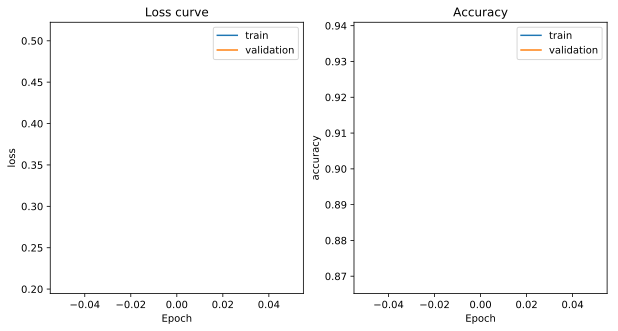

In [36]:
# get the training and validation accuracy from the history object
train_acc = history1.history['acc']
valid_acc = history1.history['val_acc']

# get the loss
train_loss = history1.history['loss']
valid_loss = history1.history['val_loss']

# get the number of entries
xvalues = np.arange(len(train_acc))

# visualize
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

In [37]:
# What is the final loss and accuracy on our validation data?
valid_loss, valid_acc = model.evaluate_generator(valid_data_gen, steps=nb_valid_steps)
print(f"Final validation accuracy: {valid_acc*100:.2f}%")

Final validation accuracy: 95.96%
